We start this notebook by typing a "magic" command that allows iPython notebooks to display plots directly in the browser.

In [1]:
# Render our plots inline
%matplotlib inline

In order to read and process files, we are going to use a very powerful, and widely used Python library, called pandas. So, our next step is to import the pandas library in Python, and also import the library matplotlib for generating plots:

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

Pandas should already be installed on your machine, but if you get an error in the import statement above, indicating that pandas is not available, please uncomment the following command and execute:

In [3]:
# !sudo python3 -m pip install -U pandas

And we type some code to simply change the visual style of the plots. (The code below is optional and not necessary, and for now you do not need to understand what exactly is happening.)

In [4]:
# Make the graphs a bit bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

### Basic Example: Creating a DataFrame from Scratch

This is an example of creating a dataframe by passing a list of dictionaries.

In [ ]:
df = pd.DataFrame([ 
    {"First Name": "Panos", "Last Name":" Ipeirotis"},
    {"First Name": "John", "Last Name":" Doe"},
    {"Last Name":"Trump"}
])


In [ ]:
df

### Reading Data Files

Let's take a look at the restaurant inspections file (at `data/restaurants.csv`), which we used in our earlier classes.

If you do not have it, then uncomment and execute the following:

In [ ]:
!mkdir data

In [ ]:
!curl 'https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD' -o data/restaurant.csv

In [ ]:
!rm data/restaurant.csv.gz

In [ ]:
!gzip data/restaurant.csv

In [ ]:
!gzip -cd data/restaurant.csv.gz | head -3

### Reading a CSV file

We want to be able to read and process this file within Python. The pandas library has a very convenient method `read_csv` which reads the file, and returns back a variable that contains its contents.

In [ ]:
import pandas as pd
restaurants = pd.read_csv("data/restaurant.csv.gz", 
                          encoding='utf_8', 
                          dtype = 'unicode',
                          parse_dates = True,
                          infer_datetime_format = True,
                          low_memory=False)

When you read a CSV, you get back a kind of object called a DataFrame, which is made up of rows and columns. You get columns out of a DataFrame the same way you get elements out of a dictionary. Let's take a look at how the object looks like:

In [ ]:
restaurants.head(5)

The read_csv method has many options, and you can read further in the [online documentation](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.parsers.read_csv.html).

### Descriptive statistics

We can use the method "describe()" to get a quick overview of the data in the dataframe.

In [ ]:
restaurants.describe()

We can also check the data types for each column

In [ ]:
restaurants.dtypes

The `object` type is a string. For many of these, we would like to change the data types for a few columns, using the `pd.to_numeric` and `pd.to_datetime` functions:

In [ ]:
restaurants["SCORE"] = pd.to_numeric(restaurants["SCORE"])
restaurants.dtypes

In [ ]:
restaurants.SCORE.hist(bins=50)

In [ ]:
restaurants.SCORE.describe()

Now let's convert the dates columns into the appropriate data types:

In [ ]:
restaurants["GRADE DATE"] = pd.to_datetime(restaurants["GRADE DATE"], format="%m/%d/%Y")
restaurants["RECORD DATE"] = pd.to_datetime(restaurants["RECORD DATE"], format="%m/%d/%Y")
restaurants["INSPECTION DATE"] = pd.to_datetime(restaurants["INSPECTION DATE"], format="%m/%d/%Y")

In [ ]:
restaurants.dtypes

In [ ]:
restaurants[["INSPECTION DATE", "GRADE DATE", "RECORD DATE"]].describe()

In [ ]:
restaurants["BORO"] =  pd.Categorical(restaurants["BORO"], ordered=False)
restaurants["GRADE"] =  pd.Categorical(restaurants["GRADE"], categories = ['A', 'B', 'C'], ordered=True)
restaurants["VIOLATION CODE"] =  pd.Categorical(restaurants["VIOLATION CODE"], ordered=False)
restaurants["CRITICAL FLAG"] =  pd.Categorical(restaurants["CRITICAL FLAG"], ordered=False)
restaurants["ACTION"] =  pd.Categorical(restaurants["ACTION"], ordered=False)
restaurants["CUISINE DESCRIPTION"] =  pd.Categorical(restaurants["CUISINE DESCRIPTION"], ordered=False)
restaurants.dtypes

In [ ]:
restaurants.describe(include='all')

### Selecting a subset of the columns

In a dataframe, we can specify the column(s) that we want to keep, and get back another dataframe with just the subset of the columns that we want to keep.

In [ ]:
restaurants["VIOLATION CODE"].head(5)

In [ ]:
column_list = ["INSPECTION DATE","VIOLATION CODE", "DBA", "SCORE"]
restaurants[ column_list ].head(10)

In [ ]:
restaurants[ ["GRADE DATE","VIOLATION CODE", "DBA"] ].head(5)

We can also get quick statistics about the common values that appear in each column:

In [ ]:
restaurants["DBA"].value_counts()[:10] 

In [ ]:
restaurants["CUISINE DESCRIPTION"].value_counts()[:5].plot(kind='bar')

In [ ]:
violation_counts = restaurants["VIOLATION CODE"].value_counts();
violation_counts[0:10]

And we can use the "plot" command to plot the resulting histogram. (More details at http://pandas.pydata.org/pandas-docs/stable/visualization.html) We also revisit plotting below.

In [ ]:
violation_counts[0:20].plot(kind='bar')

In [ ]:
popular = restaurants["CUISINE DESCRIPTION"].value_counts()
popular[:15].plot(kind='bar')

### Selecting rows

To select rows, we can use the following approach, where we generate a list of boolean values, one for each row of the dataframe, and then we use the list to select which of the rows of the dataframe we want to keep"

In [ ]:
# Create the condition "has mice" for code 04L
mice = (restaurants["VIOLATION CODE"] == "04L")
mice

In [ ]:
# Apply the condition to the dataframe "restaurants" and store the result 
# in a dataframe called  has_mice
has_mice = restaurants[mice]
has_mice

In [ ]:
# List the most frequent DBA values in the dataframe
has_mice["DBA"].value_counts()[:20]

In [ ]:
has_mice["CAMIS"].value_counts()[:5]

In [ ]:
condition = (restaurants["CAMIS"] == '41444879')
restaurants[condition]

And we can use more complex conditions:

In [ ]:
mice_manhattan =  ( (restaurants["VIOLATION CODE"] == "04L") 
                    & (restaurants["BORO"] == "MANHATTAN") 
                    & (restaurants["ZIPCODE"] == "10012") )

In [ ]:
has_mice_10012 = restaurants[mice_manhattan]
has_mice_10012

In [ ]:
has_mice_10012["DBA"].value_counts()[:20]

In [ ]:
has_mice_10012["DBA"].value_counts()[:10].plot(kind='bar')

### Pivot Tables

[Pivot tables](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) is one of the most commonly used exploratory tools, and in Pandas they are extremely flexible. 

For example, let's try to count the number of restaurants that are inspected every day. 

In [ ]:
pivot = pd.pivot_table(
    data = restaurants, 
    index = 'INSPECTION DATE', # specifies the rows
    values = 'CAMIS',  # specifies the content of the cells
    aggfunc = 'count' # we ask to count how many different CAMIS values we see
)

##### Changing date granularity 

We can also use the [resample](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) command to change the frequency from one day, to, say, 7 days. Then we can compute, say, the average (`mean()`) for these days, or the total number (`sum()`) of inspections.

In [ ]:
pivot.resample('1M').mean()

Now, let's plot this. By default, Pandas considers the "index" column to be the x-axis, and plots the rest.

In [ ]:
pivot.head(5)

In [ ]:
pivot.plot()

#### Deleting rows from a DataFrame

Hm, that '1900-01-01' line is messing things up. Let's delete it, using the `drop` command. Notice a few things:
* We use the `pd.to_datetime` command to convert the '1900-01-01' string into a datetime data type.
* We use the `axis=0` parameter means that we delete a **row** with that index value. (The `axis=1` means that we delete a column.)
* The `inplace=True` means that we change directly the dataframe, instead of returning a new dataframe that does not have the deleted value.

In [ ]:
pivot.drop(pd.to_datetime('1900-01-01'), axis=0, inplace=True) 

And let's plot again.

In [ ]:
pivot.plot()

In [ ]:
pivot.resample('1M').sum().plot()

#### Pivot Table with two (or more) variables)

We would like to break down the results by borough, so we add the `column` parameter.

In [ ]:
pivot2 = pd.pivot_table(
    data = restaurants, #
    index = 'INSPECTION DATE', 
    columns = 'BORO', 
    values = 'CAMIS', 
    aggfunc = 'count'
)

In [ ]:
pivot2.head(10)

##### Deleting rows and columns

Now, you will notice that there are a few columns and rows that are just noise. The first row with date *'1900-01-01'* is clearly noise, and the *'Missing'* columns the same. We can use the `drop` command of Pandas to drop these.

In [ ]:
# The "axis=0" means that we delete a row with that index value
pivot2 = pivot2.drop(pd.to_datetime('1900-01-01'), axis=0) 

In [ ]:
# The "axis=1" means that we delete a columns with that value
pivot2 = pivot2.drop('Missing', axis=1)

In [ ]:
# We resample the index, to keep only dates every one month
# For that one month period, we compute the average value
pivot2.resample('1M').mean()

In [ ]:
# If we plot a dataframe then by default the index column
# in our case the INSPECTION DATE becomes the x-asis
# and all the columns become separate lines in the plot
pivot2.resample('1M').mean().plot()

### Exercise 

Now let's do the same exercise, but instead of counting the number of inspections, we want to compute the average score assigned by the inspectors. Hint: We will need to change the `values` and the `aggfunc` parameters in the `pivot_table` function above.

In [ ]:
pivot = pd.pivot_table(
    data = restaurants, 
    index = 'INSPECTION DATE', # specifies the rows
    columns = 'BORO',
    values = 'SCORE',  # specifies the content of the cells
    aggfunc = 'mean' # we ask to count how many different CAMIS values we see
)
pivot.resample('1M').mean().plot(
    xlim = (pd.Timestamp('2014-01-01'), pd.Timestamp('2017-12-31')),
    figsize=(10,5) )

### Exercise

* We interacted with the NYC Restaurant Inspection Data. Now, let's download another dataset, and do some analysis. We will focus on the [NYPD Vehicle Collissions](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95/data) data set.


* Task 1: Download the dataset. Use the "Export" view, get the URL for the CSV file, and dowload it using curl. (See the top of the notebook for guidance.) 


In [ ]:
!curl 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD' -o accidents.csv

In [5]:
accidents = pd.read_csv("accidents.csv", low_memory=False)

In [6]:
accidents.dtypes

DATE                              object
TIME                              object
BOROUGH                           object
ZIP CODE                          object
LATITUDE                         float64
LONGITUDE                        float64
LOCATION                          object
ON STREET NAME                    object
CROSS STREET NAME                 object
OFF STREET NAME                   object
NUMBER OF PERSONS INJURED          int64
NUMBER OF PERSONS KILLED           int64
NUMBER OF PEDESTRIANS INJURED      int64
NUMBER OF PEDESTRIANS KILLED       int64
NUMBER OF CYCLIST INJURED          int64
NUMBER OF CYCLIST KILLED           int64
NUMBER OF MOTORIST INJURED         int64
NUMBER OF MOTORIST KILLED          int64
CONTRIBUTING FACTOR VEHICLE 1     object
CONTRIBUTING FACTOR VEHICLE 2     object
CONTRIBUTING FACTOR VEHICLE 3     object
CONTRIBUTING FACTOR VEHICLE 4     object
CONTRIBUTING FACTOR VEHICLE 5     object
UNIQUE KEY                         int64
VEHICLE TYPE COD


* Task 2: Find out the most common contributing factors to the collisions. 
 

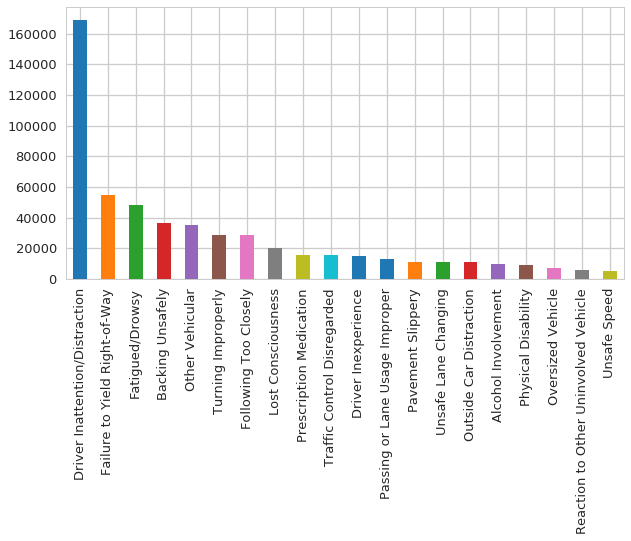

In [12]:
(
    accidents['CONTRIBUTING FACTOR VEHICLE 1'] # take the contributing factor
    .value_counts()[1:21] # compute the most frequent values and take the 
                         #top-20 (excluding top element which is "Unspecified")
    .plot(kind='bar', figsize=(10,5)) # and plot the result
)

   
* Task 3: Break down the number of collisions by borough.





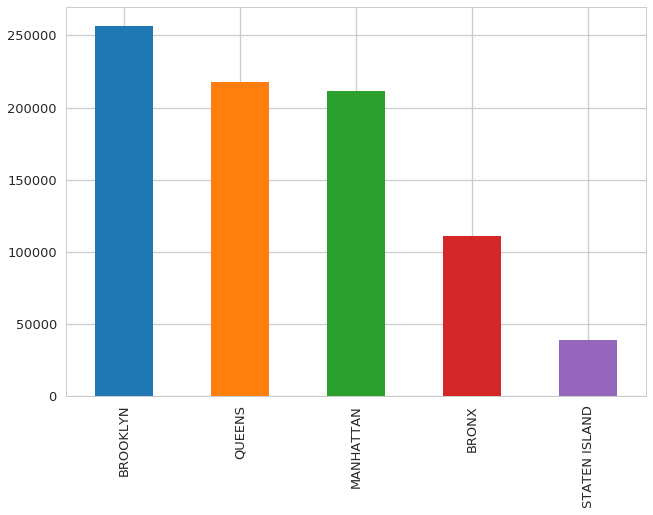

In [16]:
accidents['BOROUGH'].value_counts().plot(kind='bar')

* Task 4: Find out the how many collisions had 0 persons injured, 1 persons injured, etc. persons injured in each accident. Use the `value_counts()` approach. You may also find the `.plot(logy=True)` option useful when you create the plot to make the y-axis logarigthmic.
 

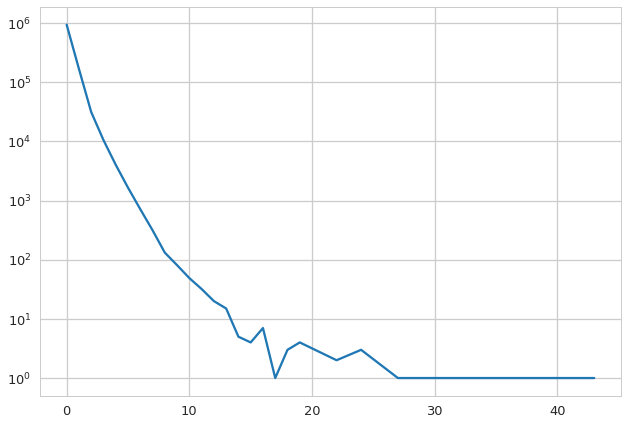

In [26]:
(
    accidents['NUMBER OF PERSONS INJURED']
    .value_counts()
    .sort_index()
    .plot(logy=True)
)

   
* Task 5: Break down the accidents by borough and contributing factor. Use the `pivot_table` function of Pandas
 

In [27]:
accidents.dtypes

DATE                              object
TIME                              object
BOROUGH                           object
ZIP CODE                          object
LATITUDE                         float64
LONGITUDE                        float64
LOCATION                          object
ON STREET NAME                    object
CROSS STREET NAME                 object
OFF STREET NAME                   object
NUMBER OF PERSONS INJURED          int64
NUMBER OF PERSONS KILLED           int64
NUMBER OF PEDESTRIANS INJURED      int64
NUMBER OF PEDESTRIANS KILLED       int64
NUMBER OF CYCLIST INJURED          int64
NUMBER OF CYCLIST KILLED           int64
NUMBER OF MOTORIST INJURED         int64
NUMBER OF MOTORIST KILLED          int64
CONTRIBUTING FACTOR VEHICLE 1     object
CONTRIBUTING FACTOR VEHICLE 2     object
CONTRIBUTING FACTOR VEHICLE 3     object
CONTRIBUTING FACTOR VEHICLE 4     object
CONTRIBUTING FACTOR VEHICLE 5     object
UNIQUE KEY                         int64
VEHICLE TYPE COD

In [30]:
pivot = pd.pivot_table(
    data = accidents, 
    index = 'CONTRIBUTING FACTOR VEHICLE 1', # specifies the rows
    columns = 'BOROUGH', # specifies the colums
    aggfunc = 'count', # and we want to count the number of accidents
    values = 'UNIQUE KEY'  # and this one has a unique value per accident
)
pivot

BOROUGH,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
CONTRIBUTING FACTOR VEHICLE 1,,,,,
Accelerator Defective,65.0,115.0,74.0,90.0,22.0
Aggressive Driving/Road Rage,464.0,799.0,732.0,583.0,101.0
Alcohol Involvement,1081.0,2119.0,1231.0,2198.0,384.0
Animals Action,56.0,104.0,48.0,118.0,107.0
Backing Unsafely,3785.0,8482.0,6567.0,8647.0,1240.0
Brakes Defective,367.0,670.0,399.0,498.0,146.0
Cell Phone (hand-held),19.0,41.0,31.0,24.0,4.0
Cell Phone (hands-free),14.0,52.0,55.0,33.0,6.0
Driver Inattention/Distraction,13885.0,29215.0,33506.0,33973.0,5554.0


 * Task 6: Find the dates with the most accidents. Can you figure out what happened on these days? 


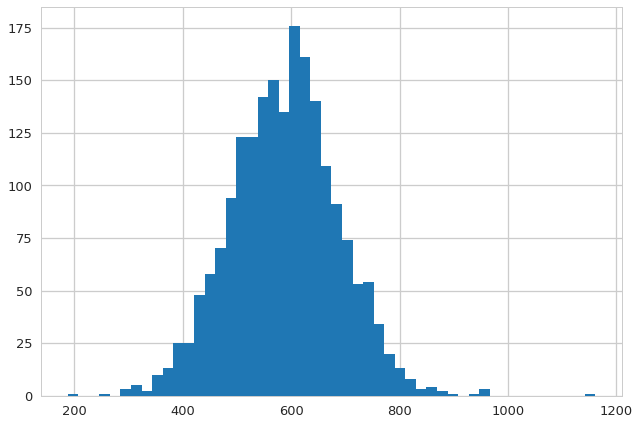

In [36]:
accidents['DATE'].value_counts().hist(bins=50)


* Task 7: Plot the number of accidents per day. (Hint: Ensure that your date column is in the right datatype and that it is properly sorted, before plotting)


In [39]:
accidents.DATE.head(5)

0    11/27/2017
1    11/27/2017
2    11/27/2017
3    11/27/2017
4    11/27/2017
Name: DATE, dtype: object

In [40]:
accidents["DATE"] = pd.to_datetime(accidents["DATE"], format="%m/%d/%Y")

In [50]:
pivot = pd.pivot_table(
    data = accidents, 
    index = 'DATE', # specifies the rows
    columns = 'BOROUGH', # specifies the colums
    aggfunc = 'count', # and we want to count the number of accidents
    values = 'UNIQUE KEY'  # and this one has a unique value per accident
)

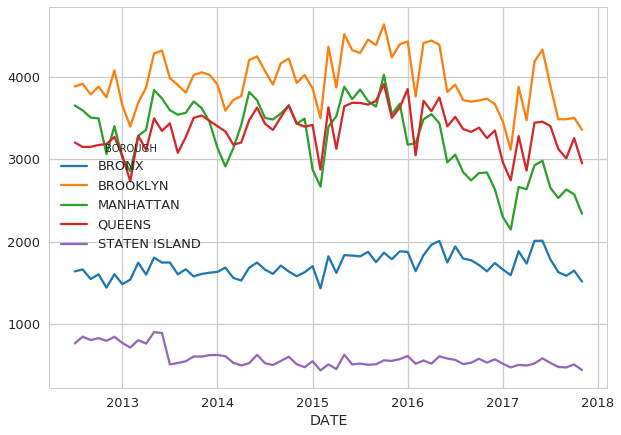

In [61]:
(
    pivot
    .resample('1M') # resample for montly periods
    .sum() # calculate the total number of collisions 
    .plot(
        figsize=(10,7)
    ) 
)

* Task 8: Plot the accidents in map. Use a scatter plot using the `plot(kind='scatter', x=..., y=....)` command, and use the `LATITUDE` and `LONGITUDE` parameters. (Hint: **You will have to remove bad data points before getting into the right visual result**. To do this, specify a selection condition to limit the lat/long values to be values that are proper for the NYC region.)

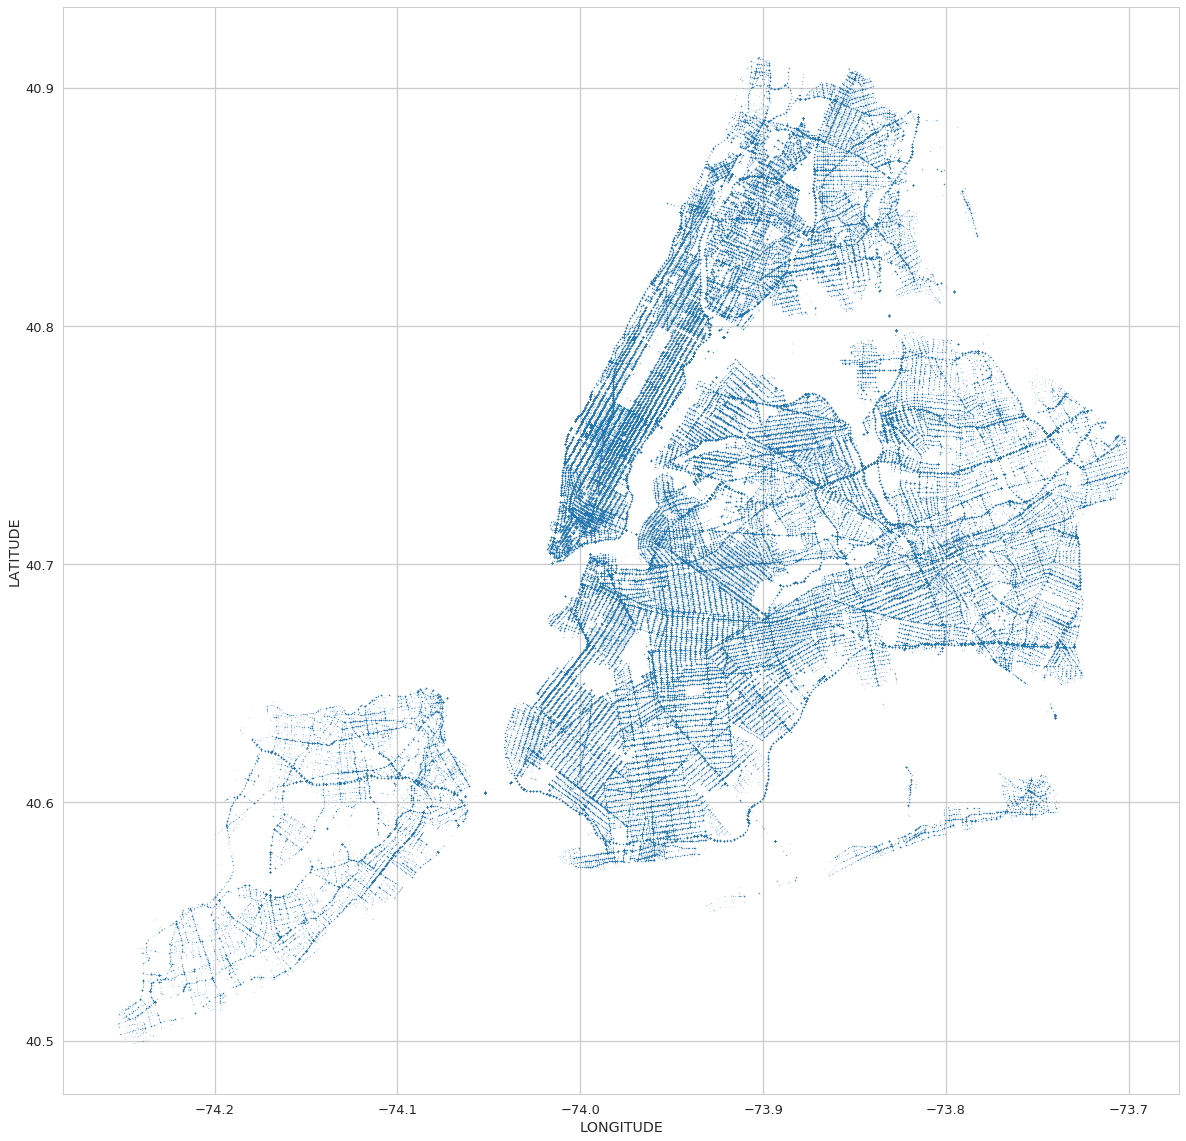

In [70]:
accidents[
    # These conditions will remove from consideration
    # the data points that are noisy
    (accidents.LONGITUDE > -74.5) &
    (accidents.LONGITUDE < -70) &
    (accidents.LATITUDE > 40) &
    (accidents.LATITUDE < 41)
].plot(
    kind='scatter',
    x = 'LONGITUDE',
    y = 'LATITUDE',
    figsize = (20,20), # fix the aspect ratio
    s = 1, # make the size of each data point just 1 pixel
    alpha = 0.1, # make each data point more transparent, allowing dense areas to show up
)

* Task 9: Plot the accidents in map as above, but limit the data only to accidents with at least one injury.

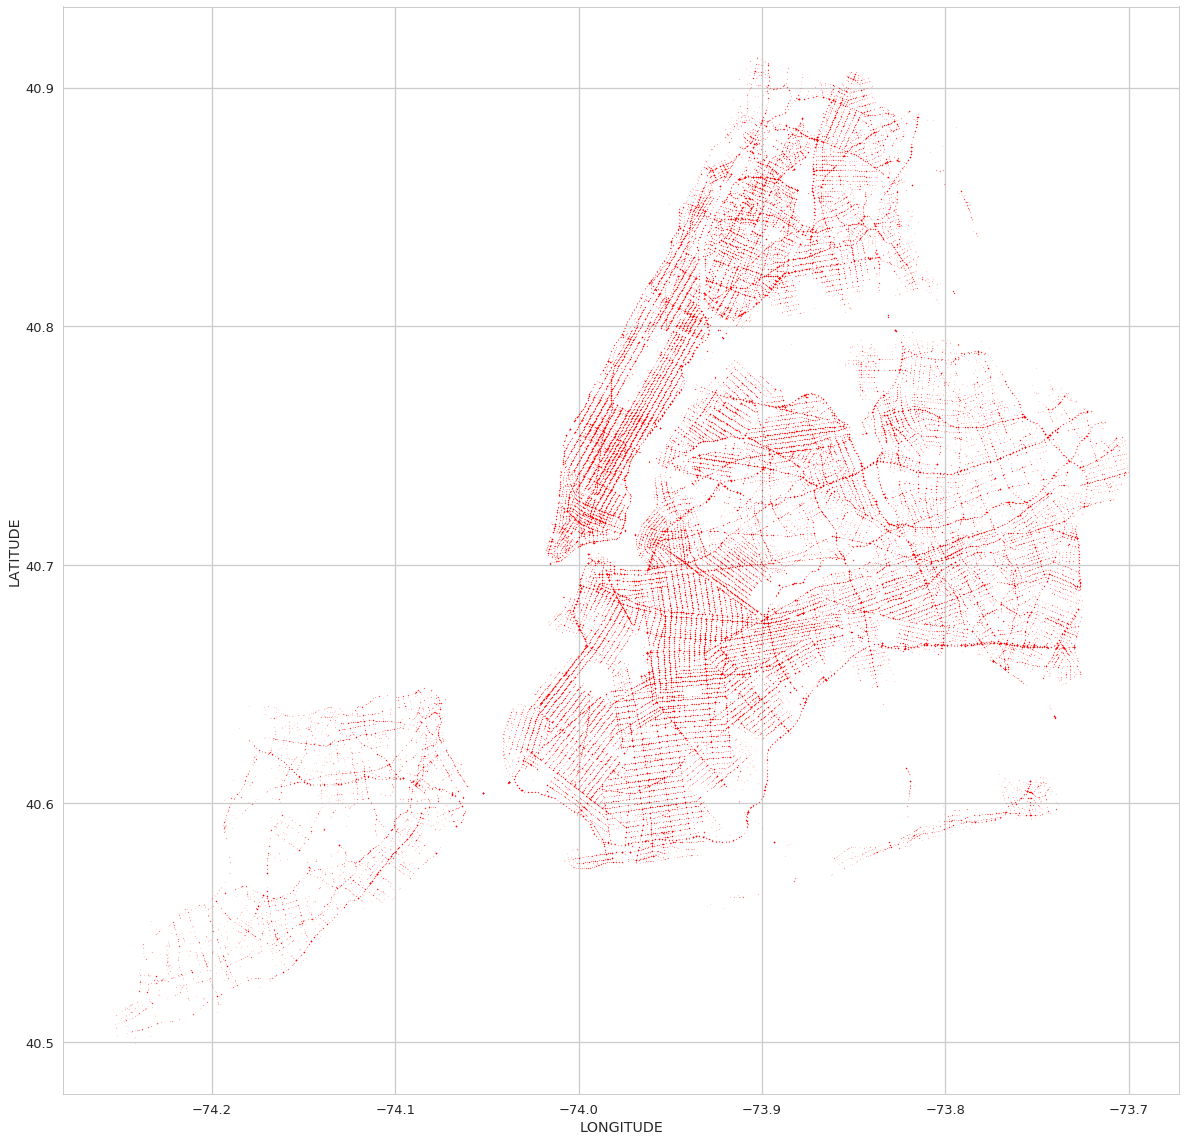

In [73]:
accidents[
    # These conditions will remove from consideration
    # the data points that are noisy
    (accidents.LONGITUDE > -74.5) &
    (accidents.LONGITUDE < -70) &
    (accidents.LATITUDE > 40) &
    (accidents.LATITUDE < 41) & 
    (accidents['NUMBER OF PERSONS INJURED'] >= 1)
].plot(
    kind='scatter',
    x = 'LONGITUDE',
    y = 'LATITUDE',
    color = 'red',
    figsize = (20,20), # fix the aspect ratio
    s = 1, # make the size of each data point just 1 pixel
    alpha = 0.1, # make each data point more transparent, allowing dense areas to show up
)

### Bonus plot

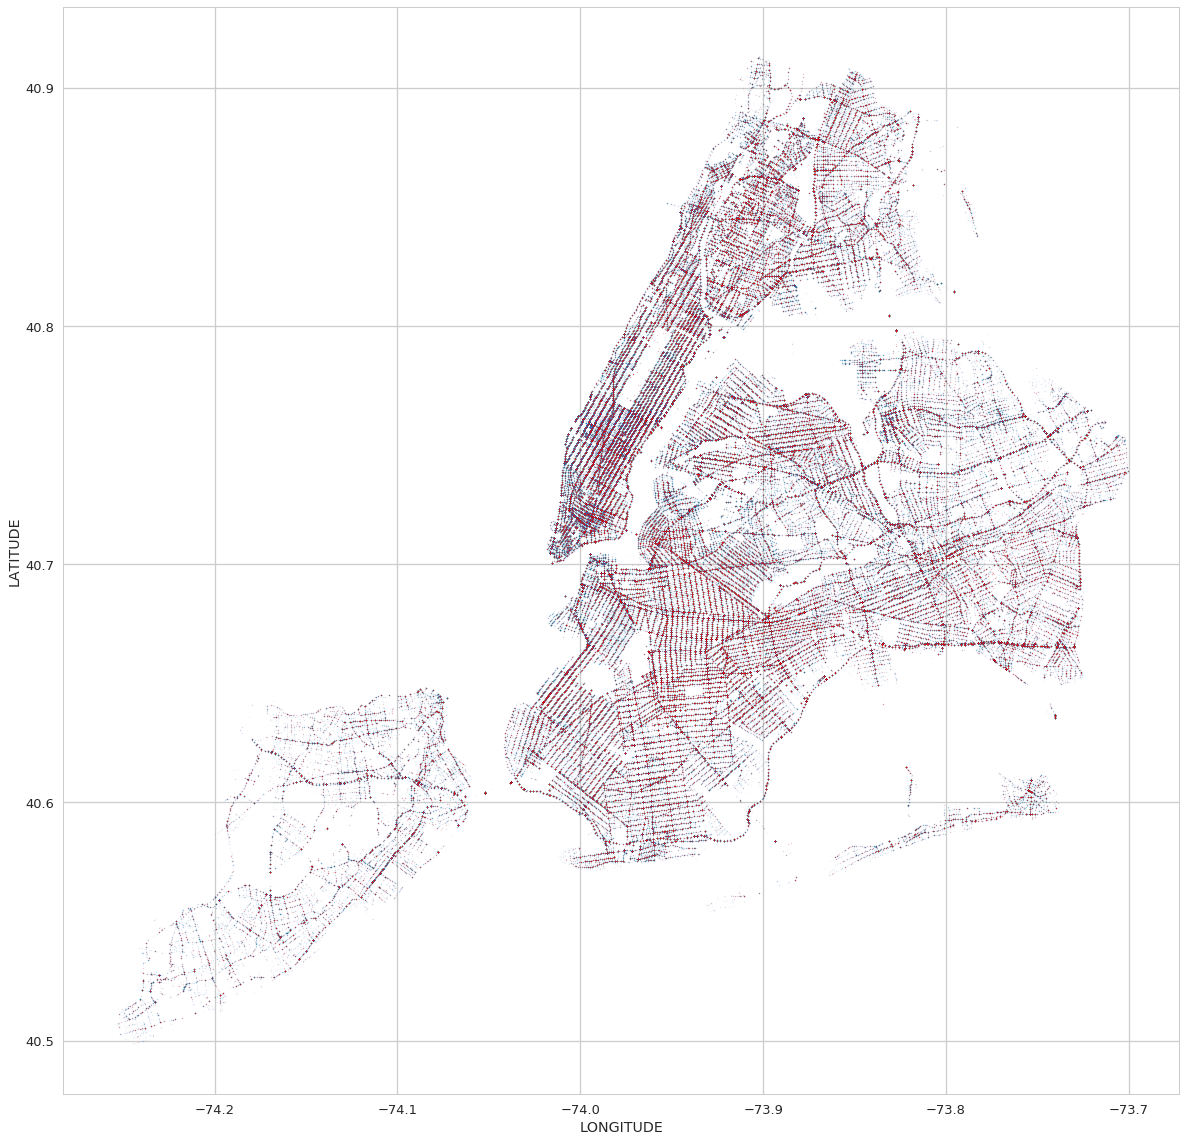

In [75]:
# In the code below, we create one plot (in blue) for all the accidents
# and another plot (with red dots) for all the accidents with injuries
# We can combine the two plots using the "ax" parameter

# df = pd.read_csv("accidents.csv", low_memory=False)

all_accidents_plot = accidents [
    # We put conditions to keep only rows that 
    # have reasonable values for LONGITUDE and LATITUDE
    (accidents.LATITUDE > 40) & # The & character is the "AND" in Pandas
    (accidents.LATITUDE < 41) & # the df.LATITUDE is equivalent to df['LATITUDE']
    (accidents.LONGITUDE < -50) &
    (accidents.LONGITUDE > -74.5) 
].plot (
    kind='scatter',
    x = 'LONGITUDE',
    y = 'LATITUDE',
    figsize = (20, 20), # changes the size of the plot to be bigger and square
    alpha = 0.05, # makes the data points transparent (1 = opaque, 0 fully transparent)
    s = 1 # make the size of the market just 3 pixel
)

accidents[
    # We put conditions to keep only rows that 
    # have reasonable values for LONGITUDE and LATITUDE
    (accidents.LATITUDE > 40) & # The & character is the "AND" in Pandas
    (accidents.LATITUDE < 41) & # the df.LATITUDE is equivalent to df['LATITUDE']
    (accidents.LONGITUDE < -50) &
    (accidents.LONGITUDE > -74.5) & 
    (accidents['NUMBER OF PERSONS INJURED']>=1) # we want only accidents with at least one injury
    # note that we cannot use the df.NUMBER OF PERSON INJURED notation
    # because the attribute contains spaces.
].plot (
    kind='scatter',
    x = 'LONGITUDE',
    y = 'LATITUDE',
    figsize = (20, 20), # changes the size of the plot to be bigger and square
    alpha = 0.1, # makes the data points transparent (1 = opaque, 0 fully transparent)
    s = 1, # make the size of the market just 3 pixel
    color = 'red',
    ax = all_accidents_plot # the ax parameter allows us to combine plots
)